### This notebook shows how to use recurrent neural network for one-step forecast of power consumption.

In [1]:
import sys
import numpy as np
import pandas as pd

from datetime import timedelta as td
import dateutil.parser

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'])

# sort dataframe
df = df.sort_values(by='Datetime').reset_index(drop=True)

df.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


In [3]:
df.tail()

,Datetime,EKPC_MW
45329,2018-08-02 20:00:00,1815.0
45330,2018-08-02 21:00:00,1769.0
45331,2018-08-02 22:00:00,1756.0
45332,2018-08-02 23:00:00,1619.0
45333,2018-08-03 00:00:00,1448.0


# Explore data

In [4]:
print(df.shape) # shape
print()
print(df.info()) # general info
print()
df.isna().sum() # missing values

(45334, 2)

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
Datetime    45334 non-null datetime64[ns]
EKPC_MW     45334 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.4 KB
None



Datetime    0
EKPC_MW     0
dtype: int64

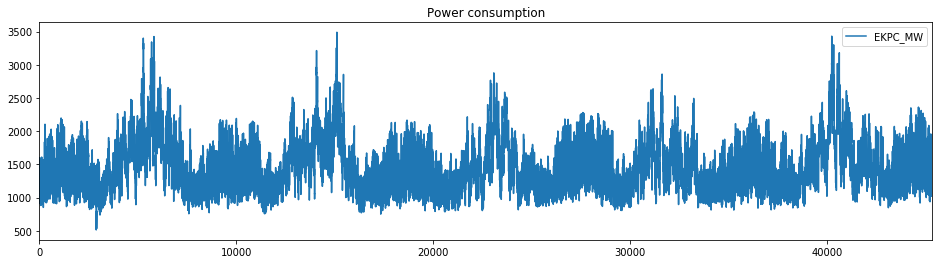

In [5]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Create pipeline

In [6]:
# Custom Transformer: Encode calendar data
class DatetimeProcessor(BaseEstimator, TransformerMixin):
    # Class Constructor 
    def __init__(self):
        pass
    
    # Return self nothing else to do here    
    def fit(self, X, y=None):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return np.concatenate([X['Datetime'].apply(lambda x: x.month).values.reshape(-1,1), 
                               X['Datetime'].apply(lambda x: int(x.day/7)).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.weekday()).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.hour).values.reshape(-1,1)], axis=1)

# preprocessing pipeline
feature_transformer = Pipeline(steps=[('calendar', DatetimeProcessor()),
                                      ('onehot', OneHotEncoder(sparse=False))])

# transformer for scaling target variable
target_transformer = MinMaxScaler(feature_range=(0.1, 4.1))

# Split data

In [7]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[df.Datetime < dateutil.parser.parse("2016-01-01")]
df_valid = df[(df.Datetime >= dateutil.parser.parse("2016-01-01")) & (df.Datetime < dateutil.parser.parse("2017-01-01"))]
df_test = df[df.Datetime >= dateutil.parser.parse("2017-01-01")]

# numpy data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22654, 48) y_train = (22654, 1)
X_valid = (8784, 48) y_valid = (8784, 1)
X_test = (13896, 48) y_test = (13896, 1)


In [8]:
# organize data in a way suitable for tensorflow model
def get_data(x_vals, y_vals, Tx=24):

    x, y = [], []
    
    for i in range(Tx, x_vals.shape[0]-1):
        x.append( np.concatenate((x_vals[i-Tx:i,:], y_vals[i-Tx:i,:]), axis=1) )
        y.append([y_vals[i]])    
   
    # convert to numpy arrays and return    
    return np.array(x), np.array(y)

# get data sets for tensorflow
x_train_tf, y_train_tf = get_data(X_train, y_train)
x_valid_tf, y_valid_tf = get_data(X_valid, y_valid)
x_test_tf, y_test_tf = get_data(X_test, y_test)

# print shape of array
print('x_train_tf = {} y_train_tf = {}'.format(x_train_tf.shape, y_train_tf.shape))
print('x_valid_tf = {} y_valid_tf = {}'.format(x_valid_tf.shape, y_valid_tf.shape))
print('x_test_tf = {} y_test_tf = {}'.format(x_test_tf.shape, y_test_tf.shape))

x_train_tf = (22629, 24, 49) y_train_tf = (22629, 1, 1)
x_valid_tf = (8759, 24, 49) y_valid_tf = (8759, 1, 1)
x_test_tf = (13871, 24, 49) y_test_tf = (13871, 1, 1)


# Build tensorflow model

## Architecture: sequence to one model

<!--- -->
<img src="images/energy/seq2one_l3.png" width="700" height="400" style="float: center"/>


In [9]:
def build_model(nx, Tx=24):
    # inputs
    x = Input(shape=(Tx, nx))

    # layers
    o, _, _ = LSTM(128, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001))(x)
    o, _, _ = LSTM(64, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001))(o)
    _, h, _ = LSTM(64, return_sequences=False, return_state=True, kernel_regularizer=reg_l2(0.001))(o)
    y = Dense(1, activation='linear')(h)
    
    # model
    model = Model(inputs=x, outputs=y)
    model.compile(optimizer="adam", loss="mse")
    
    return model


# model
model = build_model(nx=x_train_tf.shape[2], Tx=24)
model.summary()

Model: &quot;functional_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 49)]          0         
_________________________________________________________________
lstm (LSTM)                  [(None, 24, 128), (None,  91136     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 24, 64), (None, 6 49408     
_________________________________________________________________
lstm_2 (LSTM)                [(None, 64), (None, 64),  33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 173,633
Trainable params: 173,633
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
fname_best_model = 'models/energy/onestep/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_model,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train model
history = model.fit(x_train_tf, y_train_tf, 
                    validation_data=(x_valid_tf, y_valid_tf), epochs=100, shuffle=False, callbacks=callbacks)

# Load the weights with the best error on validation data
model.load_weights(fname_best_model)

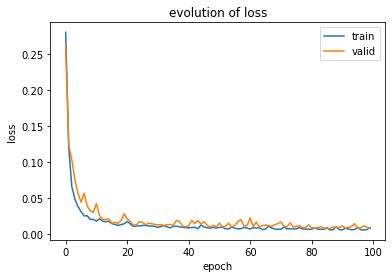

In [11]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [12]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# train data
y_train_true = y_train_tf.squeeze()
y_train_pred = model.predict(x_train_tf).squeeze()
print("Train data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_train_true, y_train_pred),
                                                  mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = y_valid_tf.squeeze()
y_valid_pred = model.predict(x_valid_tf).squeeze()
print("Valid data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_valid_true, y_valid_pred),
                                                  mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = y_test_tf.squeeze().T
y_test_pred = model.predict(x_test_tf).squeeze()
print("Test data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_test_true, y_test_pred),
                                                 mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MSE=0.0055 MAPE=4.6174
Valid data: MSE=0.0050 MAPE=4.3877
Test data: MSE=0.0051 MAPE=4.1958


## Plot all forecasts

In [13]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

In [14]:
# concatenate all true values and all predictions

# true values
y_all_train_true = target_transformer.inverse_transform( y_train_true.reshape(-1, 1) )
y_all_valid_true = target_transformer.inverse_transform( y_valid_true.reshape(-1, 1) )
y_all_test_true = target_transformer.inverse_transform( y_test_true.reshape(-1, 1) )

# predicted values
y_all_train_pred = target_transformer.inverse_transform( y_train_pred.reshape(-1, 1) )
y_all_valid_pred = target_transformer.inverse_transform( y_valid_pred.reshape(-1, 1) )
y_all_test_pred = target_transformer.inverse_transform( y_test_pred.reshape(-1, 1) )

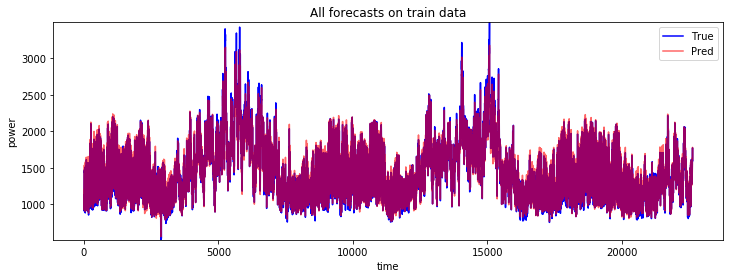

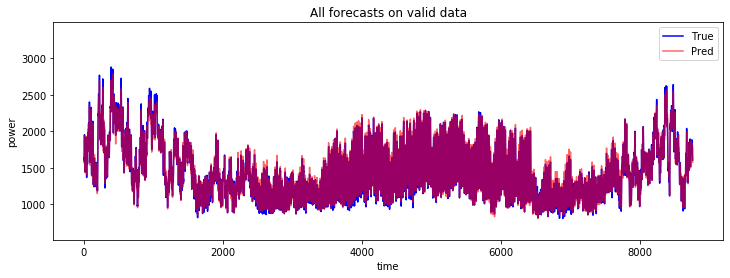

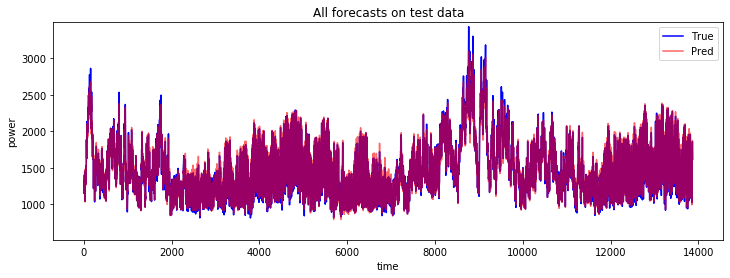

In [15]:
# plot the results
plot_predictions(y_all_train_true, y_all_train_pred, title='All forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_all_valid_true, y_all_valid_pred, title='All forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_all_test_true, y_all_test_pred, title='All forecasts on test data', xlim=None, ylim=ylim)
